# ELAIS-N2 master catalogue
## Preparation of Spitzer Adaptation of the Red-sequence Cluster Survey (SpARCS) data

This catalogue comes from `dmu0_SpARCS`. Alexandru Tudorica confirmed that the magnitudes are AB ones and are not aperture corrected.

In the catalogue, we keep:

- The internal identifier (this one is only in HeDaM data);
- The position;
- The ugrz magnitudes in the 8th aperture (11×0.186=2.046 arcsec).
- The "auto" magnitudes.

Is there y band data?

The maps on the web page indicate they were observed in 2012 (or late 2011). Let's use 2012 as epoch.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
ae28a36 (Mon Jul 10 16:31:54 2017 +0100)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates, nb_plot_mag_ap_evol, nb_plot_mag_vs_apcor
from herschelhelp_internal.utils import aperture_correction, astrometric_correction, mag_to_flux

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "sparcs_ra"
DEC_COL = "sparcs_dec"

## I - Parametres for aperture correction

To compute aperture correction we need to dertermine two parametres: the target aperture and the range of magnitudes for the stars that will be used to compute the correction.

**Target aperture**: To determine the target aperture, we simulate a curve of growth using the provided apertures and draw two figures:
- The evolution of the magnitudes of the objects by plotting on the same plot aperture number vs the mean magnitude.
- The mean gain (loss when negative) of magnitude is each aperture compared to the previous (except for the first of course).

As target aperture, we should use the smallest (i.e. less noisy) aperture for which most of the flux is captures.

**Magnitude range**: To know what limits in aperture to use when doing the aperture correction, we plot for each magnitude bin the correction that is computed and its RMS. We should then use the wide limits (to use more stars) where the correction is stable and with few dispersion.

In [4]:
# We are using the aperture index 7 (0 base) that correspond to 11 pix * 0.186 arcsec/pix = 2.046 arcsec
AP_INDEX = 7

In [5]:
t = Table.read("../../dmu0/dmu0_SpARCS/data/SpARCS_HELP_ELAIS-N2.fits")

stellarity = t['CLASS_STAR']

mags_r = np.array(t['MAG_APER_r']).T
mags_r[mags_r == 99] = np.nan

mags_u = np.array(t['MAG_APER_u']).T
mags_u[mags_u == 99] = np.nan

mags_g = np.array(t['MAG_APER_g']).T
mags_g[mags_g == 99] = np.nan

mags_z = np.array(t['MAG_APER_z']).T
mags_z[mags_z == 99] = np.nan

del t

### I.a r-band

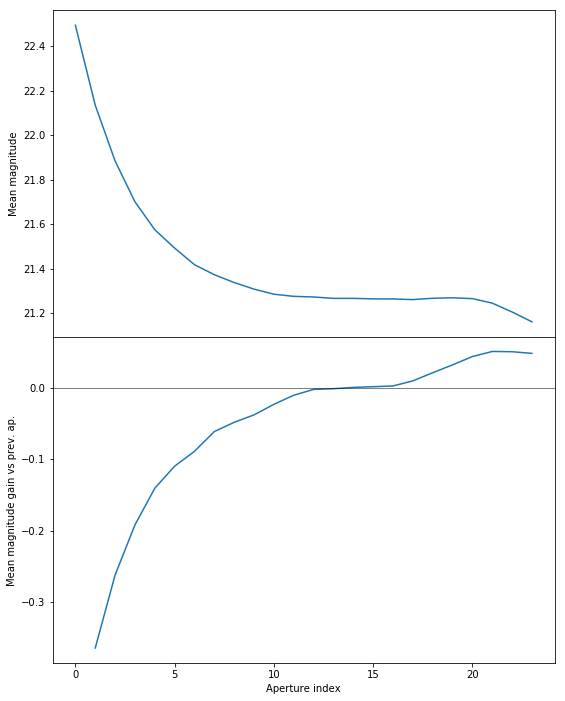

In [6]:
nb_plot_mag_ap_evol(mags_r, stellarity)

We will use the 16th (aperture number above begin to 0) aperture as target.

/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag >= mag_min)
/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag <= mag_max)


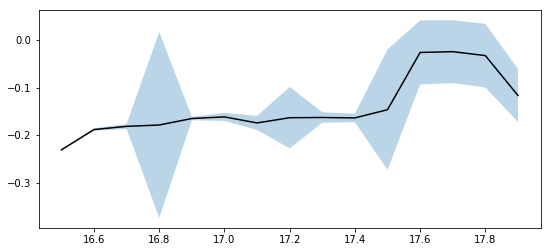

In [7]:
nb_plot_mag_vs_apcor(mags_r[AP_INDEX], mags_r[15], stellarity)

We use magnitudes between 17 and 17.9.

### I.b u-band

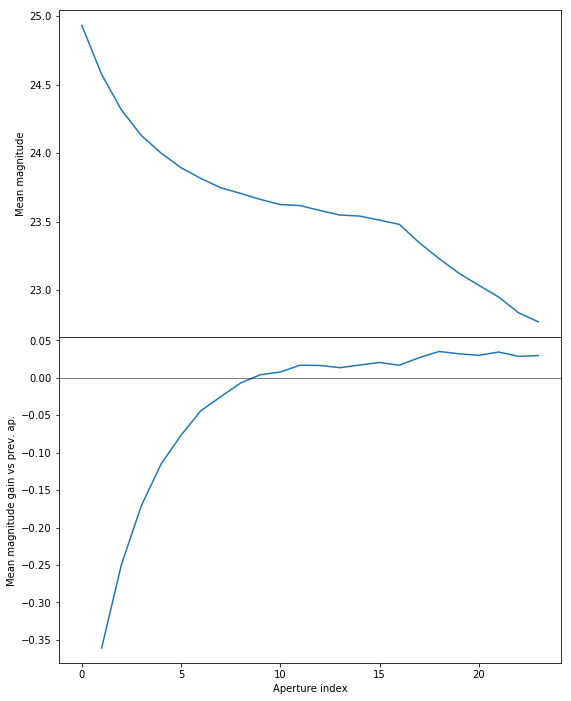

In [8]:
nb_plot_mag_ap_evol(mags_u, stellarity)

We will use the 16th (aperture number above begin to 0) aperture as target. Should we use the 12nd because of the increasing magnitude?

/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag >= mag_min)
/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag <= mag_max)


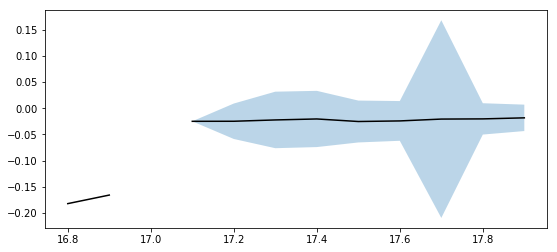

In [9]:
nb_plot_mag_vs_apcor(mags_u[AP_INDEX], mags_u[15], stellarity)

We use magnitudes between 17 and 17.9.

### I.c g-band

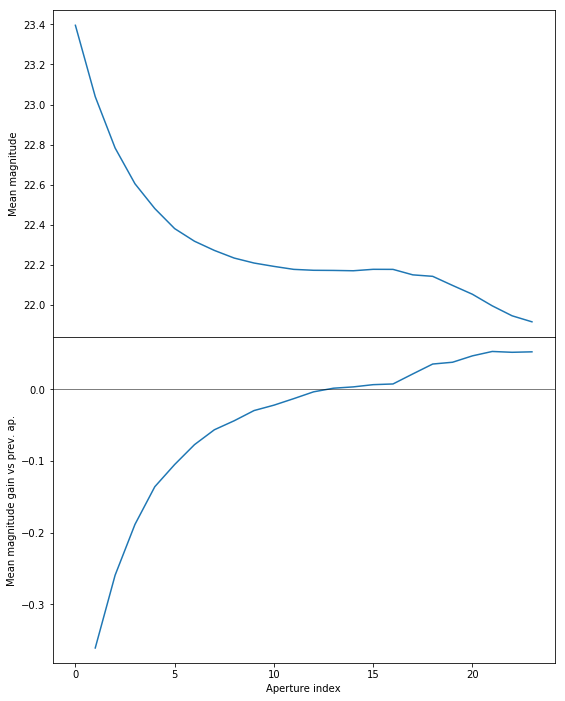

In [10]:
nb_plot_mag_ap_evol(mags_g, stellarity)

We will use the 16th (aperture number above begin to 0) aperture as target.

/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag >= mag_min)
/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag <= mag_max)


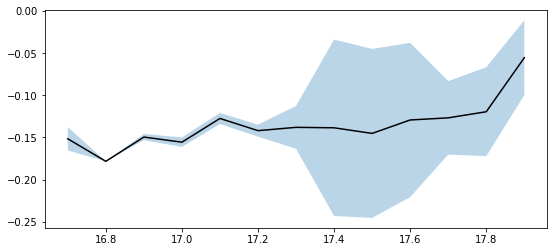

In [11]:
nb_plot_mag_vs_apcor(mags_g[AP_INDEX], mags_g[15], stellarity)

We use magnitudes between 17.2 and 18.

### I.d z-band

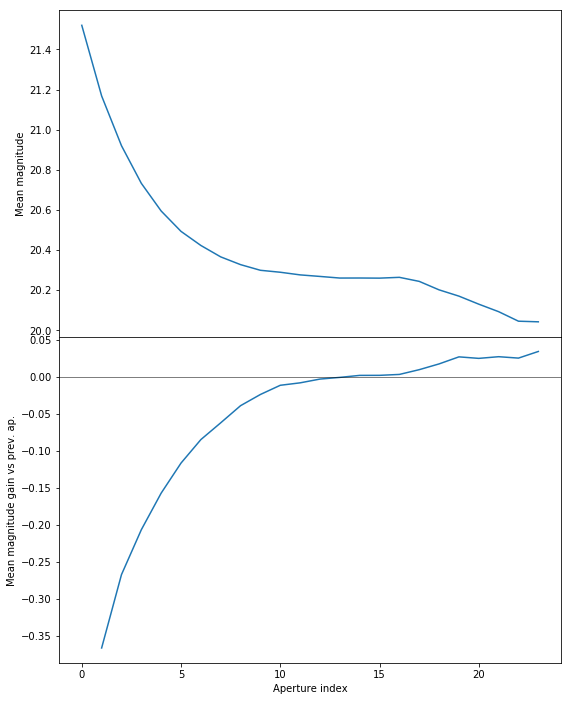

In [12]:
nb_plot_mag_ap_evol(mags_z, stellarity)

We will use the 16th (aperture number above begin to 0) aperture as target.

/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag >= mag_min)
/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag <= mag_max)


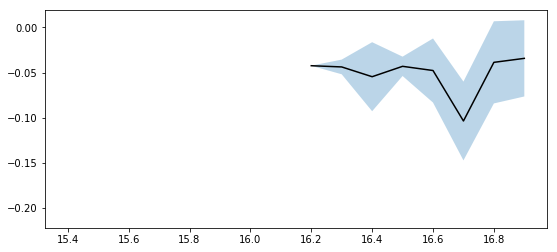

In [13]:
nb_plot_mag_vs_apcor(mags_z[AP_INDEX], mags_z[15], stellarity)

We use magnitudes between 16 and 17.

## II - Column selection

In [14]:
# Index of the target aperture when doing aperture correction
# (see 'sparcs_aperture_correction' notebook).
AP_TARG_INDEX = {
    'u': 15,
    'g': 15,
    'r': 15,
    'z': 15
}

# Magnitude range for aperture correction (see 'sparcs_aperture_correction' notebook).
APCOR_MAG_LIMITS = {
    'u': (17., 17.9),
    'g': (17., 17.9),
    'r': (17.2, 18.),
    'z': (16., 17.)
}

epoch = 2012

sparcs_tmp = Table.read("../../dmu0/dmu0_SpARCS/data/SpARCS_HELP_ELAIS-N2.fits")[
    'internal_id', 'ALPHA_J2000', 'DELTA_J2000', 'CLASS_STAR',      
    'MAG_APER_r', 'MAGERR_APER_r', 'MAG_AUTO_r', 'MAGERR_AUTO_r',
    'MAG_APER_u', 'MAGERR_APER_u', 'MAG_AUTO_u', 'MAGERR_AUTO_u',
    'MAG_APER_g', 'MAGERR_APER_g', 'MAG_AUTO_g', 'MAGERR_AUTO_g',
    'MAG_APER_z', 'MAGERR_APER_z', 'MAG_AUTO_z', 'MAGERR_AUTO_z']


# Clean table metadata
sparcs_tmp.meta = None

catalogue = Table(
    data = sparcs_tmp['internal_id', 'ALPHA_J2000', 'DELTA_J2000', 'CLASS_STAR'],
    names = ['sparcs_intid', 'sparcs_ra', 'sparcs_dec', 'sparcs_stellarity'])

for band in ['u', 'g', 'r', 'z']:
    
    # Aperture magnitudes
    mag_aper = sparcs_tmp["MAG_APER_{}".format(band)][:, AP_INDEX]
    mag_aper_target = sparcs_tmp["MAG_APER_{}".format(band)][:, AP_TARG_INDEX[band]]
    magerr_aper = sparcs_tmp["MAGERR_APER_{}".format(band)][:, AP_INDEX]
    
    # Set bad values (99.0) to NaN
    mask = (mag_aper > 90) | (mag_aper_target > 90) | (magerr_aper > 90)
    mag_aper[mask] = np.nan
    mag_aper_target[mask] = np.nan
    magerr_aper[mask] = np.nan
    
    # Aperture correction
    mag_diff, num, std = aperture_correction(
        mag_aper, mag_aper_target, catalogue['sparcs_stellarity'],
        mag_min=APCOR_MAG_LIMITS[band][0], mag_max=APCOR_MAG_LIMITS[band][1]
        )
    print("Aperture correction for SpARCS band {}:".format(band))
    print("Correction: {}".format(mag_diff))
    print("Number of source used: {}".format(num))
    print("RMS: {}".format(std))
    print("")
    mag_aper += mag_diff
    
    catalogue.add_column(Column(
        data = mag_aper.data,
        name = "m_ap_cfht_megacam_{}".format(band)
    ))
    catalogue.add_column(Column(
        data = magerr_aper.data,
        name = "merr_ap_cfht_megacam_{}".format(band)
    ))
    
    # Computing the aperture flux columns
    flux_aper, fluxerr_aper = mag_to_flux(mag_aper.data, magerr_aper.data)
    
    catalogue.add_column(Column(
        data = flux_aper * 1.e6,
        name = "f_ap_cfht_megacam_{}".format(band)
    ))
    catalogue.add_column(Column(
        data = fluxerr_aper * 1.e6,
        name = "ferr_ap_cfht_megacam_{}".format(band)
    ))
    
    # Auto magnitudes
    mag_auto = sparcs_tmp["MAG_AUTO_{}".format(band)]
    magerr_auto = sparcs_tmp["MAGERR_AUTO_{}".format(band)]
    
    # Set bad values (99.0) to NaN
    mask = (mag_auto > 90) | (magerr_auto > 90)
    mag_auto[mask] = np.nan
    magerr_auto[mask] = np.nan    
    
    catalogue.add_column(Column(
        data = mag_auto,
        name = "m_cfht_megacam_{}".format(band)
    ))
    catalogue.add_column(Column(
        data = magerr_auto,
        name = "merr_cfht_megacam_{}".format(band)
    ))
    
    # Computing the flux columns
    flux, fluxerr = mag_to_flux(mag_auto, magerr_auto)
    
    catalogue.add_column(Column(
        data = flux * 1.e6,
        name = "f_cfht_megacam_{}".format(band)
    ))
    catalogue.add_column(Column(
        data = fluxerr * 1.e6,
        name = "ferr_cfht_megacam_{}".format(band)
    ))
    
    # Band-flag column
    catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), 
                             name="flag_cfht_megacam_{}".format(band)
    ))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

del sparcs_tmp

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)
/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag >= mag_min)
/Users/rs548/GitHub/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag <= mag_max)


Aperture correction for SpARCS band u:
Correction: -0.022081375122070312
Number of source used: 59
RMS: 0.03802225220597822

Aperture correction for SpARCS band g:
Correction: -0.13222885131835938
Number of source used: 60
RMS: 0.03982640477070488

Aperture correction for SpARCS band r:
Correction: -0.13408470153808594
Number of source used: 153
RMS: 0.07327734327035945

Aperture correction for SpARCS band z:
Correction: -0.04521369934082031
Number of source used: 137
RMS: 0.04128968879174573



In [15]:
catalogue[:10].show_in_notebook()

idx,sparcs_intid,sparcs_ra,sparcs_dec,sparcs_stellarity,m_ap_cfht_megacam_u,merr_ap_cfht_megacam_u,f_ap_cfht_megacam_u,ferr_ap_cfht_megacam_u,m_cfht_megacam_u,merr_cfht_megacam_u,f_cfht_megacam_u,ferr_cfht_megacam_u,flag_cfht_megacam_u,m_ap_cfht_megacam_g,merr_ap_cfht_megacam_g,f_ap_cfht_megacam_g,ferr_ap_cfht_megacam_g,m_cfht_megacam_g,merr_cfht_megacam_g,f_cfht_megacam_g,ferr_cfht_megacam_g,flag_cfht_megacam_g,m_ap_cfht_megacam_r,merr_ap_cfht_megacam_r,f_ap_cfht_megacam_r,ferr_ap_cfht_megacam_r,m_cfht_megacam_r,merr_cfht_megacam_r,f_cfht_megacam_r,ferr_cfht_megacam_r,flag_cfht_megacam_r,m_ap_cfht_megacam_z,merr_ap_cfht_megacam_z,f_ap_cfht_megacam_z,ferr_ap_cfht_megacam_z,m_cfht_megacam_z,merr_cfht_megacam_z,f_cfht_megacam_z,ferr_cfht_megacam_z,flag_cfht_megacam_z
,,deg,deg,,,,,,mag,mag,,,,,,,,mag,mag,,,,,,,,mag,mag,,,,,,,,mag,mag,,,
0,4656238,248.43122419,41.7862478045,0.224474,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,nan,nan,False,18.186,0.00106274,193.019,0.188931,18.0404,0.00100153,220.711,0.203593,False,nan,nan,nan,nan,nan,nan,nan,nan,False
1,4656257,248.431298,41.7726532613,0.610302,24.7804,0.0592163,0.444481,0.0242421,24.9117,0.0686709,0.393834,0.0249093,False,24.4646,0.0205938,0.59449,0.011276,24.6362,0.0225707,0.507593,0.010552,False,24.1613,0.0465967,0.786108,0.0337375,24.2531,0.0480979,0.722397,0.0320021,False,nan,nan,nan,nan,nan,nan,nan,nan,False
2,4656272,248.431350023,41.7785256731,0.755548,nan,nan,nan,nan,25.696,0.156442,0.191244,0.027556,False,23.9319,0.0133677,0.97106,0.0119558,23.9604,0.0143796,0.945873,0.0125273,False,23.0519,0.0177173,2.18392,0.0356378,23.0813,0.0194526,2.12559,0.0380831,False,nan,nan,nan,nan,nan,nan,nan,nan,False
3,4656303,248.431470902,41.7191313875,0.635899,25.2351,0.0350486,0.292389,0.00943861,25.2852,0.0356995,0.279206,0.00918042,False,24.8694,0.0148001,0.409482,0.00558182,25.0321,0.0151344,0.352515,0.00491381,False,24.777,0.0394551,0.445841,0.0162016,24.918,0.0396516,0.391551,0.0142996,False,24.7846,0.0916284,0.442755,0.0373654,24.8656,0.094705,0.410908,0.035842,False
4,4656311,248.431515175,41.766524398,0.475051,26.0447,0.176368,0.13871,0.0225322,25.3697,0.109056,0.258299,0.0259447,False,24.4391,0.0203607,0.608653,0.011414,24.4155,0.020096,0.622029,0.0115132,False,24.3327,0.0380487,0.671294,0.0235249,24.3838,0.041039,0.640464,0.0242084,False,nan,nan,nan,nan,nan,nan,nan,nan,False
5,4656332,248.431672978,41.735266764,0.186145,25.7181,0.0634996,0.187402,0.0109603,25.5577,0.093167,0.217237,0.0186411,False,24.4819,0.0120701,0.585138,0.00650498,24.4519,0.0175057,0.601515,0.00969843,False,23.1199,0.00996183,2.05134,0.0188214,23.0911,0.0142312,2.10655,0.0276114,False,21.8528,0.00732976,6.58974,0.0444871,21.6957,0.00978886,7.61559,0.0686612,False
6,4656376,248.431866289,41.6618830796,0.114187,24.7686,0.0237793,0.449317,0.00984075,24.5885,0.0284628,0.530401,0.0139046,False,24.0767,0.00740212,0.849811,0.00579368,24.0442,0.00905929,0.875661,0.00730644,False,23.155,0.00967129,1.98609,0.0176912,23.108,0.0119334,2.07393,0.0227947,False,22.5351,0.0120206,3.51525,0.0389186,22.3528,0.0145864,4.15792,0.0558599,False
7,4656382,248.431876858,41.671185345,0.360395,nan,nan,nan,nan,30.1577,2.97394,0.00313985,0.00860037,False,nan,nan,nan,nan,26.9847,0.0796897,0.0583609,0.00428351,False,25.1538,0.0556336,0.31511,0.0161464,25.2048,0.0494791,0.300664,0.0137019,False,22.9454,0.017279,2.40894,0.0383371,23.0477,0.0173913,2.19244,0.0351185,False
8,4656388,248.431898713,41.655578691,0.98276,20.5919,0.00174753,21.0489,0.033879,20.5285,0.00186371,22.3157,0.0383058,False,18.6841,0.000317496,121.995,0.0356742,18.7124,0.000307813,118.862,0.033698,False,17.9665,0.000356142,236.259,0.0774975,17.9926,0.000357366,230.645,0.0759158,False,17.5767,0.000393474,338.316,0.122607,17.5015,0.000425226,362.574,0.142002,False


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [16]:
SORT_COLS = ['merr_ap_cfht_megacam_r', 'merr_ap_cfht_megacam_u',
              'merr_ap_cfht_megacam_g', 'merr_ap_cfht_megacam_z']
FLAG_NAME = 'sparcs_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 56911 sources.
The cleaned catalogue has 56911 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [17]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_ELAIS-N2.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

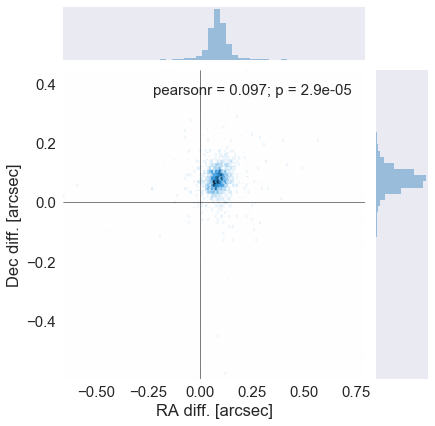

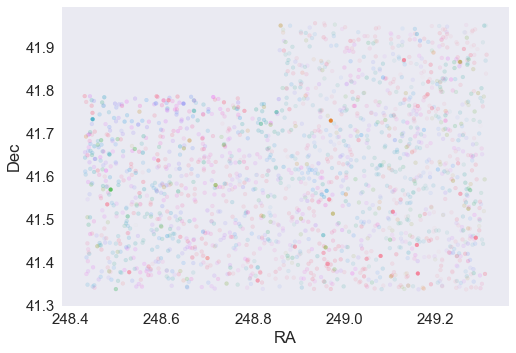

In [18]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [19]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.08527333806114257 arcsec
Dec correction: -0.07707197818831446 arcsec


In [20]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

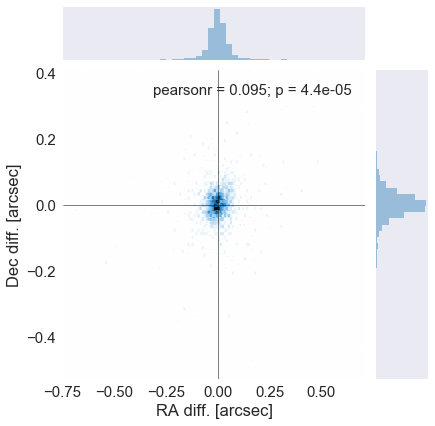

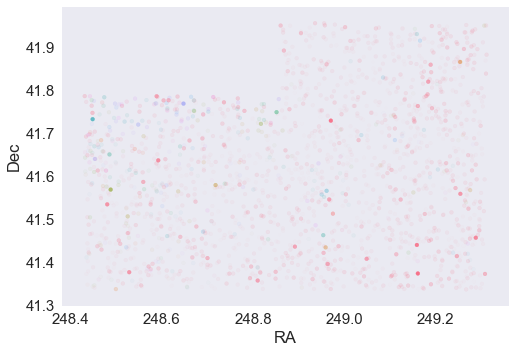

In [21]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [22]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [23]:
GAIA_FLAG_NAME = "sparcs_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

1919 sources flagged.


## V - Flagging objects near bright stars

## VI - Saving to disk

In [24]:
catalogue.write("{}/SpARCS.fits".format(OUT_DIR), overwrite=True)